## Imports

In [ ]:
!pip install statsbombpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 622.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.4 MB/s eta 0:00:00


In [ ]:
pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from statsbombpy import sb
import pandas as pd
import numpy as np
import pandas as pd
import ast
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from keras.layers import Dense, LeakyReLU, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


## Global Variables and Function Declarations

In [ ]:
game_ids = np.linspace(3788741, 3788776, 36, dtype=int)
all_match_events = {}
#two sets of columns to drop at the right after import for efficiency
rem_frame_col = ['visible_area', 'match_id', 'keeper','injury_stoppage']

rem_event_col = ['counterpress', 'miscontrol', 'goalkeeper', 'clearance', 'ball_recovery', 'foul_committed',
                 'foul_won', 'block', 'substitution', 'period', 'minute', 'second', 'carry', 'under_pressure', 'play_pattern'
                 'out', 'ball_receipt', 'interception', 'off_camera', 'dribble', 'duel', 'related_events', 'pass',
                 'match_id', 'duration', 'tactics', 'player', 'position', 'location', 'index', 'possession','team',
                 'injury_stoppage', 'bad_behaviour','50_50', 'shot']

# function to format columns correctly
def get_name_from_dict(column):
    return column['name']

def add_possession_change_column(df_2):
    # Initialize a new column 'possession_change' with zeros
    df_2['possession_change'] = 0

    df_2['possession_change'] = (df_2['possession_team'] != df_2['possession_team'].shift()).astype(int)

    df_2['possession_change'] = df_2.groupby('id')['possession_change'].transform('max')
    return df_2

## Data Pre-Processing

In [ ]:
for game_id in game_ids:
    match_events = sb.events(match_id=game_id, split=True, flatten_attrs=False, fmt='dict')
    match_events_df = pd.DataFrame(match_events).transpose()

    # Drop columns if they exist in the DataFrame
    match_events_df = match_events_df.drop(columns=rem_event_col, errors='ignore')

    # Apply transformation to get raw data without ids
    match_events_df['possession_team'] = match_events_df['possession_team'].apply(get_name_from_dict)
    match_events_df['play_pattern'] = match_events_df['play_pattern'].apply(get_name_from_dict)
    match_events_df['type'] = match_events_df['type'].apply(get_name_from_dict)

    match_frames = sb.frames(match_id=game_id, fmt='dataframe')
    match_frames.drop(columns=rem_frame_col, inplace=True, errors='ignore')
    match_frames = match_frames.groupby('id').agg({
        'teammate': list,
        'actor': list,
        'location': list
    }).reset_index()

    merged_df = pd.merge(match_frames, match_events_df, on='id', how='inner')

    df_sorted = merged_df.sort_values(by='timestamp')

    df_PC_added = add_possession_change_column(df_sorted)

    # Convert the values inside the 'location' list of lists into integers
    df_PC_added['location'] = df_PC_added['location'].apply(lambda x: [[int(coord) for coord in location] for location in x])
    df = df_PC_added

    # Convert each row in the 'actor' column to 0 if False and 1 if True
    df['actor'] = df['actor'].apply(lambda row: [1 if value else 0 for value in row])
    df['actor'] = df['actor'].apply(lambda row: [1 if value else 0 for value in row])

    # Ensure the resulting list has a length of 22, filling any remaining positions with 0
    df['actor'] = df['actor'].apply(lambda row: row + [0] * (22 - len(row)))

    # Convert each row in the 'teammate' column to 0 if False and 1 if True
    df['teammate'] = df['teammate'].apply(lambda row: [1 if value else 0 for value in row])
    df['teammate'] = df['teammate'].apply(lambda row: [1 if value else 0 for value in row])

    # Ensure the resulting list has a length of 22, filling any remaining positions with 0
    df['teammate'] = df['teammate'].apply(lambda row: row + [0] * (22 - len(row)))

    #fill with [0,0] until 22
    df['location'] = df['location'].apply(lambda row: row + [[0, 0]] * (22 - len(row)))

    df['x_coordinates'] = df['location'].apply(lambda loc: [coord[0] for coord in loc])
    df['y_coordinates'] = df['location'].apply(lambda loc: [coord[1] for coord in loc])

    df = df.drop(columns='location', errors='ignore')

    # Append the result to all_match_events
    all_match_events[game_id] = df


In [ ]:
# Create an empty DataFrame outside the loop
DataFrame = pd.DataFrame()

for game_id in game_ids:
    df = all_match_events[game_id]

    # Drop specified columns
    df = df.drop(columns=['id', 'possession_team', 'play_pattern','timestamp', 'out'])

    # Append the modified df to the DataFrame
    DataFrame = pd.concat([DataFrame, df], ignore_index=True)

print(DataFrame.tail())

                                                 teammate  \
111948  [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, ...   
111949  [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, ...   
111950  [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, ...   
111951  [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, ...   
111952  [1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, ...   

                                                    actor           type  \
111948  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  Ball Receipt*   
111949  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           Pass   
111950  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...          Carry   
111951  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  Ball Receipt*   
111952  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...           Pass   

        possession_change                                      x_coordinates  \
111948                  0  [85, 91, 92, 98, 99, 99, 102, 102, 102, 103, 1...   
111949          

## Predicting Possession Change

Vanilla Network

In [ ]:
# Assuming 'DataFrame' is the DataFrame containing the data
# Extract features and target variable
X = np.array(DataFrame[['x_coordinates', 'y_coordinates', 'actor', 'teammate']])
y = np.array(DataFrame['possession_change'])

# Flatten the lists within each element of X
X = np.array([np.concatenate(x) for x in X])

# Standardize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate class weights to handle imbalanced classes
class_weights = {0: 1, 1: 3}

model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

# Predictions on the test set
y_pred = (model.predict(X_test) > 0.4).astype(int)

test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

# plot the confusion matrix with value counts
conf_matrix = confusion_matrix(y_test, y_pred)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['No Possession Change', 'Possession Change']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix[i, :]):.2%})',
                 ha='center', va='center', color='red')

plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(classification_report(y_test, y_pred, target_names=classes))


Epoch 1/10
 737/2240 [========>.....................] - ETA: 9s - loss: 0.8038 - accuracy: 0.8351

KeyboardInterrupt: ignored

## Predicting Play Type of Current Row

In [ ]:
desired_types = ['Ball Receipt*', 'Pass', 'Carry', 'Pressure','Ball Recovery']
DataFrame = DataFrame[DataFrame['type'].isin(desired_types)]
print(DataFrame['type'].value_counts())

Ball Receipt*    31302
Pass             30867
Carry            26402
Pressure          9760
Ball Recovery     2694
Name: type, dtype: int64


Epoch 1/20
135/135 [==============================] - 3s 8ms/step - loss: 1.6359 - accuracy: 0.2333 - val_loss: 1.5614 - val_accuracy: 0.2866
Epoch 2/20
135/135 [==============================] - 1s 6ms/step - loss: 1.5742 - accuracy: 0.2686 - val_loss: 1.5438 - val_accuracy: 0.2778
Epoch 3/20
135/135 [==============================] - 1s 5ms/step - loss: 1.5579 - accuracy: 0.2820 - val_loss: 1.5236 - val_accuracy: 0.2950
Epoch 4/20
135/135 [==============================] - 1s 6ms/step - loss: 1.5350 - accuracy: 0.2964 - val_loss: 1.5053 - val_accuracy: 0.3038
Epoch 5/20
135/135 [==============================] - 1s 5ms/step - loss: 1.5230 - accuracy: 0.3052 - val_loss: 1.5035 - val_accuracy: 0.3029
Epoch 6/20
135/135 [==============================] - 1s 5ms/step - loss: 1.5157 - accuracy: 0.3157 - val_loss: 1.4989 - val_accuracy: 0.3177
Epoch 7/20
135/135 [==============================] - 1s 6ms/step - loss: 1.5063 - accuracy: 0.3118 - val_loss: 1.4941 - val_accuracy: 0.3182
Epoch 

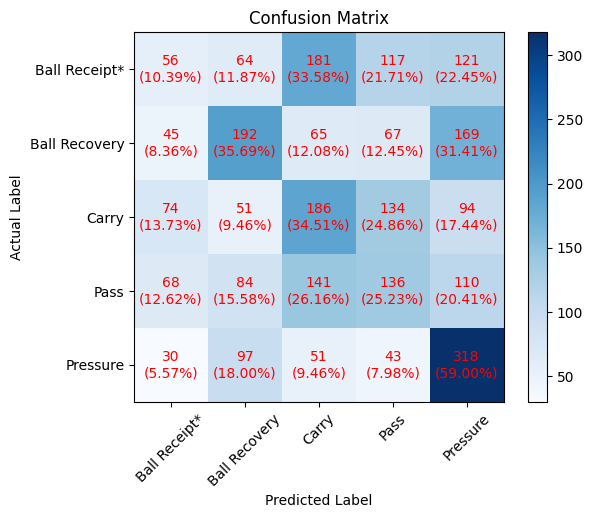

               precision    recall  f1-score   support

Ball Receipt*       0.21      0.10      0.14       539
Ball Recovery       0.39      0.36      0.37       538
        Carry       0.30      0.35      0.32       539
         Pass       0.27      0.25      0.26       539
     Pressure       0.39      0.59      0.47       539

     accuracy                           0.33      2694
    macro avg       0.31      0.33      0.31      2694
 weighted avg       0.31      0.33      0.31      2694



In [ ]:
X = np.array(DataFrame[['x_coordinates', 'y_coordinates', 'actor', 'teammate']])
y = np.array(DataFrame['type'])

X = np.array([np.concatenate(x) for x in X])

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode the categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Use random undersampling to balance the classes
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y_encoded)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Build the model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

y_pred_encoded = np.argmax(model.predict(X_test), axis=-1)

# Map predicted classes back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)


test_accuracy = accuracy_score(y_test, y_pred_encoded)
print(f'Test Accuracy: {test_accuracy:.4f}')

# plot the confusion matrix with value counts
conf_matrix = confusion_matrix(y_test, y_pred_encoded)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix[i, :]):.2%})',
                 ha='center', va='center', color='red')

plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_test, y_pred_encoded, target_names=classes))


Epoch 1/20
1566/1566 [==============================] - 46s 14ms/step - loss: 1.5000 - accuracy: 0.3110 - val_loss: 1.4373 - val_accuracy: 0.3489
Epoch 2/20
1566/1566 [==============================] - 22s 14ms/step - loss: 1.4377 - accuracy: 0.3475 - val_loss: 1.3889 - val_accuracy: 0.3677
Epoch 3/20
1566/1566 [==============================] - 21s 13ms/step - loss: 1.3981 - accuracy: 0.3660 - val_loss: 1.3399 - val_accuracy: 0.3962
Epoch 4/20
1566/1566 [==============================] - 21s 13ms/step - loss: 1.3676 - accuracy: 0.3834 - val_loss: 1.3132 - val_accuracy: 0.4151
Epoch 5/20
1566/1566 [==============================] - 21s 14ms/step - loss: 1.3455 - accuracy: 0.3953 - val_loss: 1.2887 - val_accuracy: 0.4177
Epoch 6/20
1566/1566 [==============================] - 22s 14ms/step - loss: 1.3271 - accuracy: 0.4055 - val_loss: 1.2714 - val_accuracy: 0.4330
Epoch 7/20
1566/1566 [==============================] - 20s 13ms/step - loss: 1.3096 - accuracy: 0.4126 - val_loss: 1.2472 -

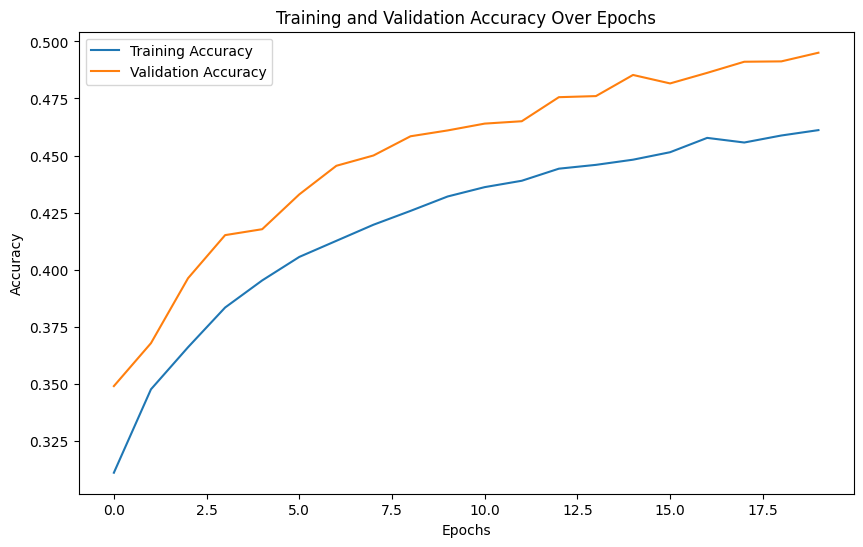

979/979 [==============================] - 4s 3ms/step
Test Accuracy: 0.4947


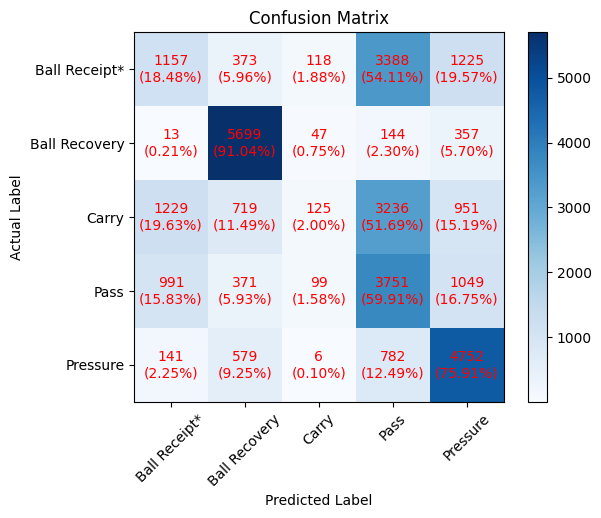

               precision    recall  f1-score   support

Ball Receipt*       0.33      0.18      0.24      6261
Ball Recovery       0.74      0.91      0.81      6260
        Carry       0.32      0.02      0.04      6260
         Pass       0.33      0.60      0.43      6261
     Pressure       0.57      0.76      0.65      6260

     accuracy                           0.49     31302
    macro avg       0.46      0.49      0.43     31302
 weighted avg       0.46      0.49      0.43     31302



In [ ]:
X = np.array(DataFrame[['x_coordinates', 'y_coordinates', 'actor', 'teammate']])
y = np.array(DataFrame['type'])

# Flatten the lists within each element of X
X = np.array([np.concatenate(x) for x in X])

scaler = StandardScaler()
X = scaler.fit_transform(X)


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Use SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Reshape the data for LSTM
X_resampled = X_resampled.reshape(X_resampled.shape[0], 1, X_resampled.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and record training and validation accuracy
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

y_pred_encoded = np.argmax(model.predict(X_test), axis=-1)

# Map predicted classes back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

test_accuracy = accuracy_score(y_test, y_pred_encoded)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_encoded)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix[i, :]):.2%})',
                 ha='center', va='center', color='red')

plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


print(classification_report(y_test, y_pred_encoded, target_names=classes))


In [ ]:
X = np.array(DataFrame[['x_coordinates', 'y_coordinates', 'actor', 'teammate']])
y = np.array(DataFrame['type'])

# Flatten the lists within each element of X
X = np.array([np.concatenate(x) for x in X])

scaler = StandardScaler()
X = scaler.fit_transform(X)


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Use SMOTE to oversample the minority class https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Reshape the data for LSTM
X_resampled = X_resampled.reshape(X_resampled.shape[0], 1, X_resampled.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and record training and validation accuracy
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

y_pred_encoded = np.argmax(model.predict(X_test), axis=-1)

# Map predicted classes back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

test_accuracy = accuracy_score(y_test, y_pred_encoded)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_encoded)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix[i, :]):.2%})',
                 ha='center', va='center', color='red')

plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_test, y_pred_encoded, target_names=classes))

In [ ]:
print(DataFame.head())

## Predicting Event Type of Next Row

This code was used in a older version of the project and was therefore built with the older data preprocessing.
Since we did not continue this path we did not update the model to be able to run on the new data preprocessing.
However, since this model was still an important step for prediciting the current event type we wanted to include this code ion the final file as well.
However, as described this code will not be able to run in this file

In [ ]:
# Encode event
encoder = OneHotEncoder(sparse=False)
encoded_event_types = encoder.fit_transform(df_2['type'].values.reshape(-1, 1))

#  Encode twM
onehot_encoder = OneHotEncoder(sparse=False)
team_encoded = onehot_encoder.fit_transform(df_2[['team']])
max_players = 22

df_2['x'] = df_2['x'].astype(int)
df_2['y'] = df_2['y'].astype(int)

def create_feature_vector(group, max_players, event_types_encoded_dict, team_encoded_dict):
    num_features = max_players * 2 + 2 + len(event_types_encoded_dict[group.name]) + len(team_encoded_dict[group.name])
    features = np.zeros(num_features)
    positions = group[['x', 'y']].values.flatten().astype(int)

    actor_data = group[group['actor']][['x', 'y']].astype(int)
    if not actor_data.empty:
        actor_position = actor_data.iloc[0].values
        features[:len(positions)] = positions
        features[-2-len(event_types_encoded_dict[group.name]):-len(event_types_encoded_dict[group.name])] = actor_position
    else:
        features[:len(positions)] = positions

    features[-len(event_types_encoded_dict[group.name]):] = event_types_encoded_dict[group.name]
    features[-len(team_encoded_dict[group.name]):] = team_encoded_dict[group.name]
    return features

encoded_event_types_dict = {id_: encoded_event_types[i] for i, id_ in enumerate(df_2['id'].unique())}

# Create a dictionary for easy access to encoded team
team_encoded_dict = {id_: team_encoded[i] for i, id_ in enumerate(df_2['id'].unique())}

feature_vectors = df_2.groupby('id').apply(lambda group: create_feature_vector(group, max_players, encoded_event_types_dict, team_encoded_dict))

# Convert feature_vectors to a 2D NumPy array
feature_array = np.stack(feature_vectors.values)

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_features = scaler.fit_transform(feature_array)

sequence_length = 15
X, y = [], []
for i in range(len(normalized_features) - sequence_length):
    X.append(normalized_features[i:i + sequence_length])
    y.append(encoded_event_types[i + sequence_length])
X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
#class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df_2['type']), y=df_2['type'])
#class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
#print(class_weights_dict)

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15,  batch_size=32)